# Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization


Introduksjon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Required to import cv2 !!!
# %pip install opencv-python
#%pip install tabulate
import cv2
from tabulate import tabulate
import pandas as pd

import os
import time

# Oppgave 1

In [2]:
def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 0):
    """
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
    """
    m, n = np.shape(V)

    if seed != 0:
        np.random.seed(seed)
    
    W0 = np.random.uniform(low=1e-20, high=1, size=m*d)
    H0 = np.random.uniform(low=1e-20, high=1, size=n*d)
    
    W0 *= np.sqrt(np.mean(V)/d)
    H0 *= np.sqrt(np.mean(V)/d)
    
    W0 = np.reshape(W0, (m, d))
    H0 = np.reshape(H0, (d, n))
    
    H_k = H0
    W_k = W0
    diff = np.zeros(maxiter)
    
    for k in range(maxiter):
        H_k = H_k*(np.dot(W_k.T, V))/(np.dot(np.dot(W_k.T, W_k), H_k)+ delta)
        W_k = W_k*(np.dot(V, H_k.T))/(np.dot(np.dot(W_k, H_k), H_k.T)+ delta)
        diff[k] = np.linalg.norm(V - np.dot(W_k, H_k))
    
    return W_k, H_k, diff

In [3]:
A1 = np.array([
    [1, 0],
    [0, 1]
])

A2 = np.array([
    [1, 2],
    [1, 1],
    [1, 2]
])

A3 = np.array([
    [2, 1, 1],
    [2, 1, 1],
    [1, 1, 2]
])

A4 = np.array([
    [2, 1, 0],
    [1, 2, 3],
    [0, 3, 3]
])

## a)

Non-negative Matrix Factorization (NMF) is a technic used to represent a matrix A, but with a lower amount of data. The NMF-representation consists of two non-negative matrices W and H, where the dot product between W and H gives an approximation to the original matrix. Combined, W and H has fewer components than A, and consequently holds lower amounts of data. If A is a m x n matrix, W and H has dimensions, respectively, m x d and d x n. With a larger d, the NMF gives a better approximation to the original data. Normally one chooses a value of d that is much smaller than both n and m. However, it is important to choose a value of d that gives a good representation of A, but do not require considerable computational power. This is something we will look more into. 

<b>Induction</b>
1. 
    $W_0$ and $H_0$ are initialzed as positive, and A is assumed to be non-negative. \
    $\Rightarrow$ $W_0$ and $H_0$ are non-negative.
2. 
    Assume $W_k$ and $H_k$ are non-negative.
3. 
    Updates are given by:
    \begin{aligned}
        (H_{k+1})_{ij} \leftarrow & (H_k)_{ij} \cdot \frac{(W^T_k A)_{ij}}{(W^T_k W_k H_K)_{ij}} \\
        (W_{k+1})_{ij} \leftarrow & (W_k)_{ij} \cdot \frac{(A H^T_{k+1})_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}}
    \end{aligned}
    Since the matrix product of two non-negative matricies is also non-negative, every matrix product in the updates are non-negative, assuming that every factor is non-negative. \
    For $(H_{k+1})_{ij}$ every factor in every matrix product is assumed to be non-negative. Meaning the final product is something non-negative and non-negative. Meaning that $(H_{k+1})_{ij}$ must be non-negative. \
    The same logic works for $(W_{k+1})_{ij}$, since we now know that $(H_{k+1})_{ij}$ is also non-negative.

Therefore all iterates $W_{k}$ and $H_{k}$ are non-negative, by induction $\Box$.

## b)

Let $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ be a matrix of ones.
\begin{aligned}
    & H_{k+1} \leftarrow H_k \odot (W^T_k A) \oslash (W^T_k W_k H_k) \\
    \Rightarrow & H_{k+1} \leftarrow H_k \odot J_{m,n} \\
    \Rightarrow &\underline{H_{k+1} \leftarrow H_k} \\
\end{aligned}
Therefore if $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ is a matrix of ones, then $H_{k+1}=H_K$ and $H_k$ is a fixed point $\Box$.


Let $W_k H_k = A$.
\begin{aligned}
    (W_k^T A) \oslash (W_k^T W_k H_k) = (W_k^T A) \oslash (W_k^T A) = J_{m,n} \\
\end{aligned}
Therefore if $W_k H_k = A$, $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ is a matrix of ones.

## c)

Let $W_0=0_{m,d}$ and $H_0=0_{d,n}$.
\begin{aligned}
    & H_{1} \leftarrow H_0 \odot (W^T_0 A) \oslash (W^T_0 W_0 H_0) \\
    \Rightarrow & H_{1} \leftarrow 0_{d,n} \odot (0_{d,m} A) \oslash (0_{d,m} 0_{m,d} 0_{d,n}) \\
    \Rightarrow & H_{1} \leftarrow 0_{d,n} \odot (0_{d,n}) \oslash (0_{d,n}) \\
\end{aligned}
This leads to being needed to calculate $0/0$, which is undefined. This is clearly problematic, and should be avoided.

# d)

In [4]:
from IPython.display import display, Math

def print_matrix(array):
    data = ''
    for line in array:        
        if len(line) == 1:
            data += ' %.3f &'%line + r' \\\n'
            continue
        for element in line:
            data += ' %.3f &'%element
        data += r' \\' + '\n'
    display(Math('\\begin{bmatrix} \n%s\end{bmatrix}'%data))

In [5]:

W_A11, H_A11, diffff = NMF(A1, 1, seed=1)
WH11 = np.dot(W_A11, H_A11)
diff_A11 = np.linalg.norm(A1 - WH11)


W_A12, H_A12, diffff = NMF(A1, 1, seed=2)
WH12 = np.dot(W_A12, H_A12)
diff_A12 = np.linalg.norm(A1 - WH12)



W_A22, H_A22 , diffffffff= NMF(A2, 1, seed = 1)
WH22 = np.dot(W_A22, H_A22)
diff_A22 = np.linalg.norm(A2 - WH22)


W_A21, H_A21 , diffffffff= NMF(A2, 1, seed = 2)
WH21 = np.dot(W_A21, H_A21)
diff_A21 = np.linalg.norm(A2 - WH21)


With one itteration of NMF on the following matrices, we get:


Initial Matrix | W | H | WH | $\lVert A-WH \rVert_F$
:-------------------|:---------------:|:---------------:|:---------------:|------------------------:
**A1**       | \begin{bmatrix}
                        0.295\\
                        0.509
                        \end{bmatrix}   | \begin{bmatrix}
                                                0.851 &
                                                1.470
                                            \end{bmatrix}  |\begin{bmatrix}
                                                                0.251 & 0.434\\
                                                                0.434 & 0.749
                                                                \end{bmatrix}| 1.0000
**A1**       |\begin{bmatrix}
                        0.308\\
                        0.018
                        \end{bmatrix}|\begin{bmatrix}
                                        3.232 &
                                        0.192
                                       \end{bmatrix}|\begin{bmatrix}
                                                        0.996 & 0.059\\
                                                        0.059 & 0.004
                                                        \end{bmatrix}|1.0000
**A2**       |\begin{bmatrix}
                        0.722\\
                        0.441\\
                        0.722
                        \end{bmatrix}|\begin{bmatrix}
                                        1.524 &
                                        2.691
                                        \end{bmatrix}|\begin{bmatrix}
                                                           1.100 & 1.943\\
                                                           0.671 & 1.186\\
                                                           1.100 & 1.943
                                                            \end{bmatrix}|0.4112
**A2**       |\begin{bmatrix}
                        0.457\\
                        0.279\\
                        0.457
                        \end{bmatrix}|\begin{bmatrix}
                                        2.405 &
                                        4.248
                                        \end{bmatrix}|\begin{bmatrix}
                                                        1.100 & 1.943 \\
                                                        0.671 & 1.186 \\
                                                        1.100 & 1.943
                                                        \end{bmatrix}|0.4112


When we compare W, H, WH and $\lVert A-WH \rVert_F$ after one iteration of NMF, there is only one quantity that is the same every time. That quantity is the $\lVert A-WH \rVert_F$, which becomes 1 with A1 as the initial grid, and 0.4112 with A2 as the initial grid. 

$\lVert A-WH \rVert_F$ is the square root of this sum of the absolute squares of the difference of the elements of the matrix. The other quantities: W, H and WH is not unique, but that is not expected since the NMF of a matrix is a non-unique approximation. Due to the non-unique approximation, there will usually be infinitely solutions to W and H, and furthermore WH. One interesting thing to take a closer look at is the matrix WH from A2, this matrix is exactly the same no matter what W and H are. because??

# e)


In [6]:
W, H, diff = NMF(A1, 2)
A = np.dot(W, H)
diff = np.linalg.norm(A1 - A)
print(f"||A1 - WH||={diff:.3e}")

W, H, diff = NMF(A2, 2)
A = np.dot(W, H)
diff = np.linalg.norm(A2 - A)
print(f"||A2 - WH||={diff:.3e}")

||A1 - WH||=5.027e-10
||A2 - WH||=1.097e-09


$\lVert A-WH \rVert$ for A1 and A2 with $d=2$ is in the range $1^{-9}$ to $1^{-10}$, which is very close to zero. In this instance $d$ is big enough to not lose any information during the NMF, since A1 is a $2x2$ matrix, and A2 is a $2x3$ matrix. As a result of the NMF we have then just increased the amount of data stored, which is the exact opposite of what we want to accomplish using the NMF. 

# f) og g)

The Rank of a matrix is defined as the maximum number of linearly independent column vectors in the matrix. It is possible to find the number of linearly independent column vectors by Gauss eliminating the matrix. A3 can be eliminated down to the matrix:
\begin{bmatrix}
1 & 0 & -1\\
0 & 1 & 3 \\
0 & 0 & 0
\end{bmatrix}
This Matrix consist of 2 linearly independent column vectors, and has Rank=2. The same process can be done to A4, but nummerically there is a easier way to figure out the rank of a matrix, by the function numpy.linalg.matrix_rank(). This function just takes in the matrix and gives out the rank directly. As is done below, and we concludes that A3 has rank=2 and A4 has rank=3.

In [7]:
print(f"A3 rank: {np.linalg.matrix_rank(A3)}\nA4 rank: {np.linalg.matrix_rank(A4)}")

A3 rank: 2
A4 rank: 3


Since the rank of the matrix is the maximum number of linearly independent columnvectors, all the other columnvectors can be described using the ones we know. $d$ is the number of columns in our factorized vector W. Therefore it is not farfetched to believe there is some sort of connection between the rank and the optimal choice of $d$. Given that we now know the rank of the matrices, we want to investigate this further. 

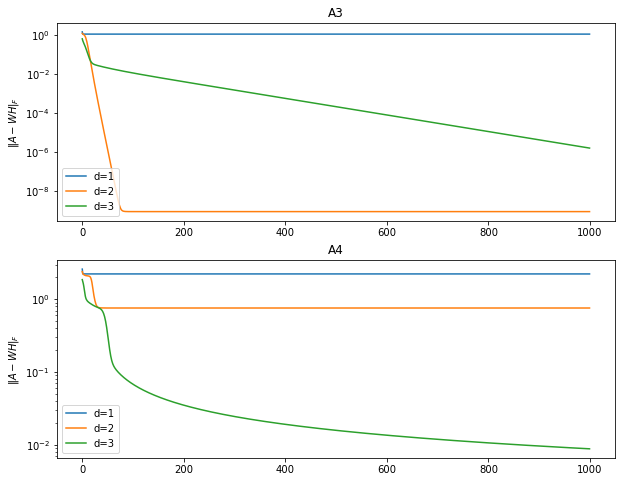

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for d in range(1, 4):
    W, H, diff = NMF(A3, d)
    ax1.semilogy(diff, label=f"d={d}")

ax1.set_title("A3")
ax1.set_ylabel(r'$\Vert A - WH \vert_{F}$')
ax1.legend()
    
for d in range(1, 4):
    W, H, diff = NMF(A4, d)
    ax2.semilogy(diff, label=f"d={d}")
    
ax2.set_title("A4")
ax2.set_ylabel(r'$\Vert A - WH \vert_{F}$')
ax2.legend()

plt.show()

As the plots indicates there is a connection between the rank and the best d. The Frobenius norm that reaches the lowest value for each of the initial matrices is the one with d equal to the rank. For A3 both $d=2$ and $d=3$ converges to approximately the same value, but $d=3$ is unstable and varies each time. For A4 $d=3$ converges to a value way lower than both $d=1,2$. One thing to note for all of the plots $\lVert A-WH \rVert$ satisfies $\lVert A-W_{k+1}H_{k+1} \rVert \leq \lVert A-W_{k}H_{k} \rVert$, but this only implies that it finds a local minimizer, and the convergens can for some initial conditions be very slow. 

# Oppgave 2

## Introduksjon

Now that NMF is both defined and implemented, it is interersting to investigate it's properties. Therefore there is a need of a large dataset to apply NMF to. The dataset which will be used is 10 000 Cryptopunks NFTs. A Cryptopunk is a digital 24 x 24 RGBA image. Every Cryptopunk is algorithmically generated, meaning certain features such as cigarettes and hairstyles are shared between images. This means that the images should be more or less able to be decomposed into image components, so that every image can be described as a sum of image components. To verify this claim we are going to make us of the NMF-algorithm to approximate such a components and decompisitions.

Now we need to represent the data in such a way that it is possible to apply the NMF-algorithm. Firstly we randomly select N Cryptopunks from the pool of 10 000. This gives 500 24 x 24 RGBA images. A natural way to store the images is to store them in a 24 x 24 x 4 x N array, i.e. 24 rows x 24 columns x 4 color channels x N images. Below is a function which loads 500 randomly picked images from the dataset a stores them in an array as described. One thing to note is that the RGBA-values are divided by 255.0. This is to create a array of floats, with values from 0 to 1.

In [9]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
                
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)

(24, 24, 4, 500)


With the images now being loaded into the kernel it is now possible to plot and view some of the images picked. Below is a function which plots the first $nplot^2$ images in the input array in a square grid. After the implementation a 8 x 8 grid of the images loaded in the kernel are plotted.

In [10]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

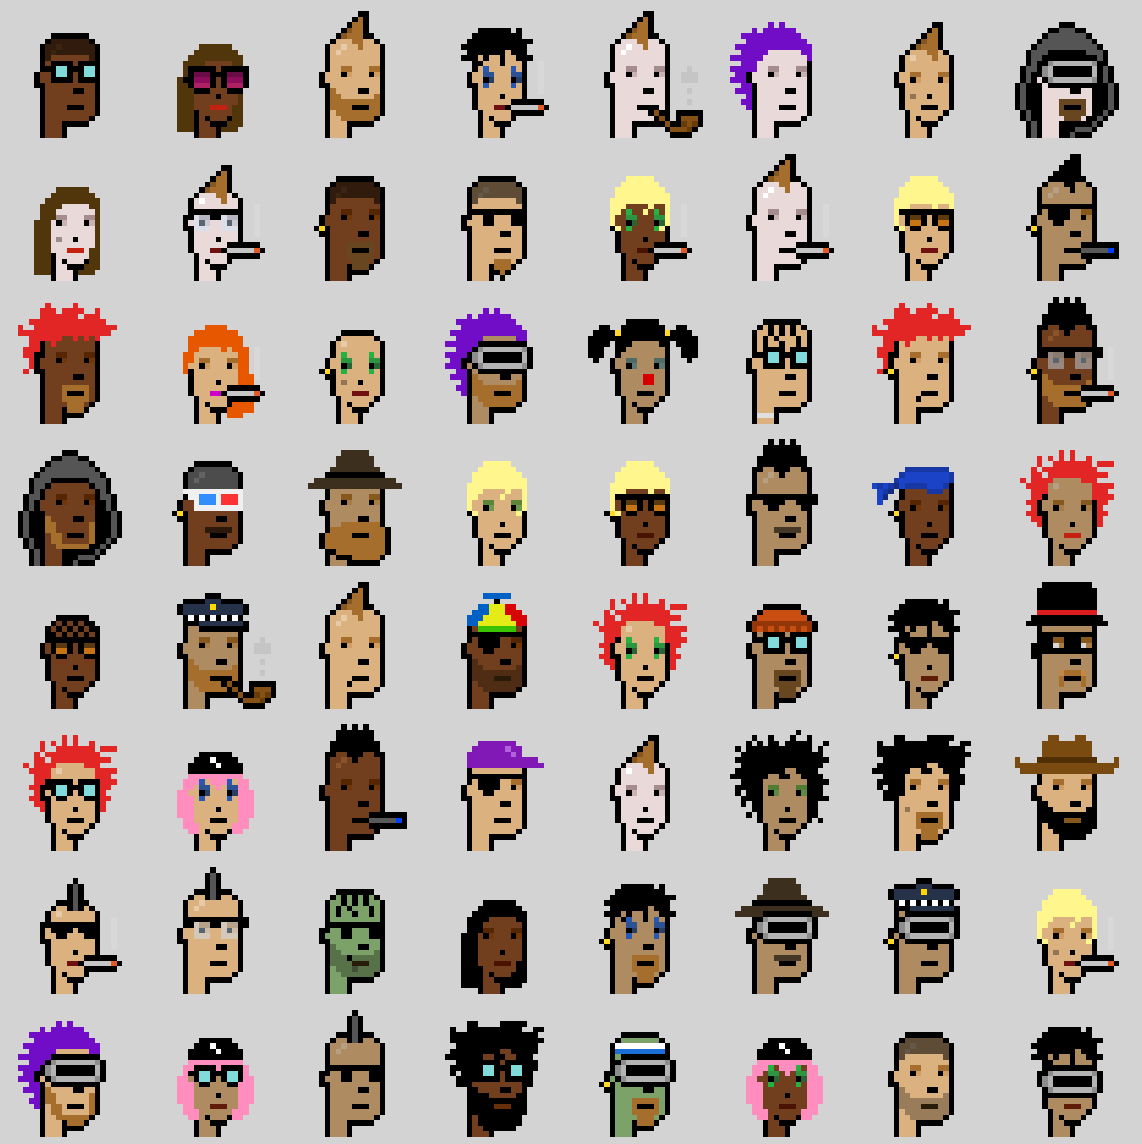

In [11]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

In the above images some common features are clearly possible to be seen, which is a good indication that the NMF-algorithm should be able to reduce the amount of data to store the images. We will now start applying the NMF-algorithm to verify our previous claims, and to see if the algorithm is able to decompose the images into image components.

# 2b)

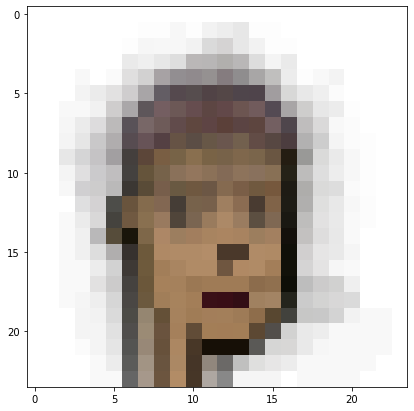

In [12]:
 # Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
faces_opacity.shape

faces_mean = np.mean(faces, -1)

plt.figure(figsize = (7,7))
plt.imshow(faces_mean)
plt.show()

# 2 c)

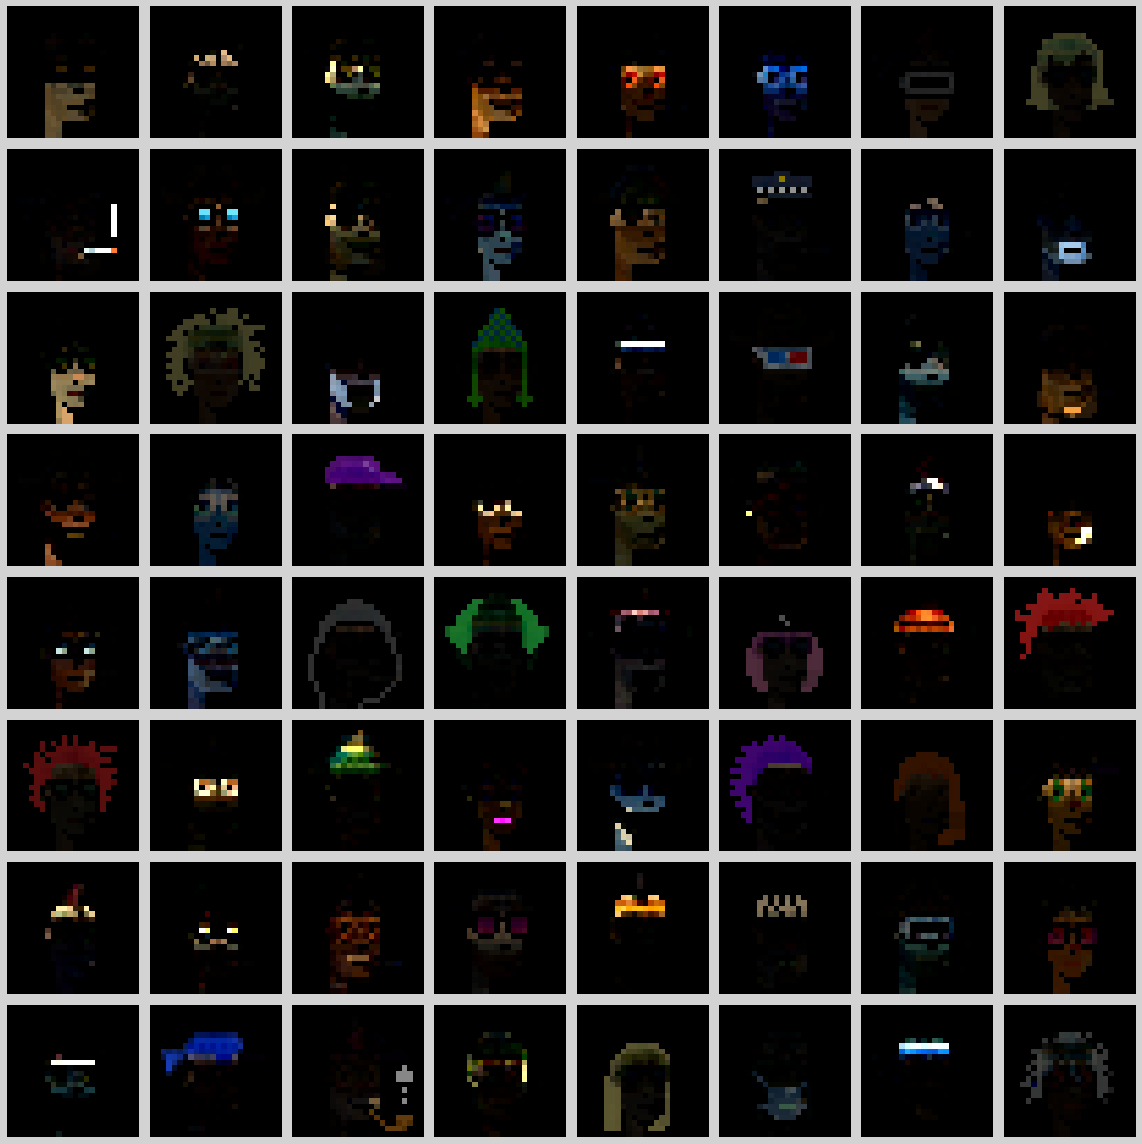

In [13]:
d = 64

W_k, H_k, diff = NMF(faces_reshaped, d)

W_k_reshape = W_k.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én

plotimgs(W_k_reshape, 8)

# 2d)

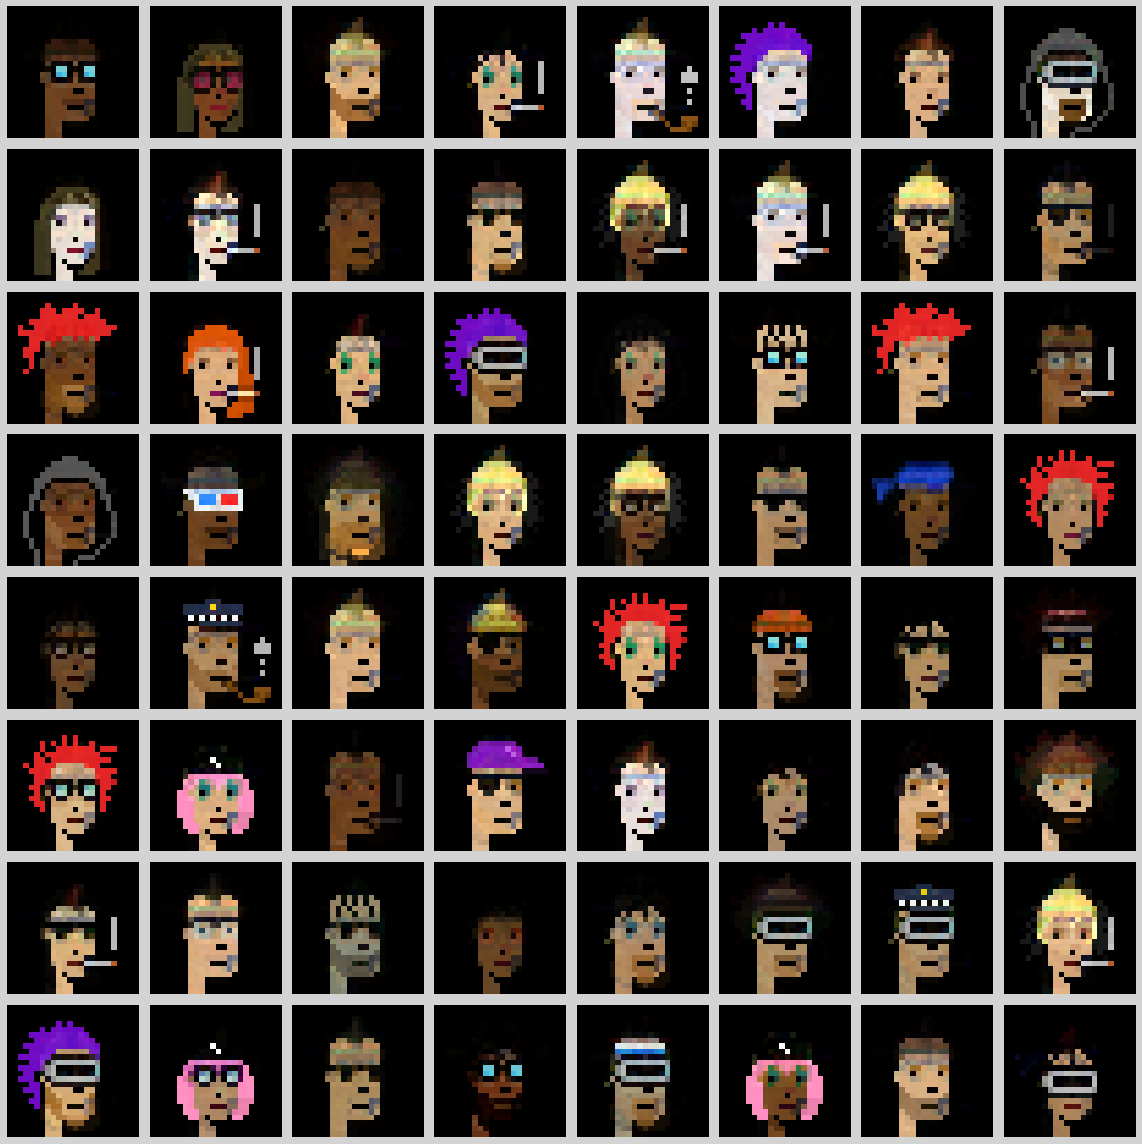

In [14]:
reconstruction = np.dot(W_k, H_k).reshape(24, 24, 3, 500)
reconstruction[reconstruction > 1] = 1

plotimgs(reconstruction, 8)

# 2 e)

As we saw that the difference between the initial matrix and the final reconstruction WH got smaller the closer to zero the closer $d$ was to the rank of the matrix. Here $d$ has another meaning.

Faces_reshaped rank: 378


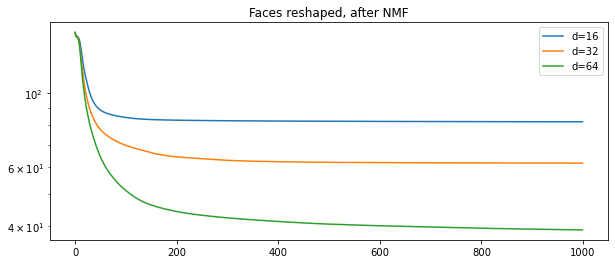

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
print(f"Faces_reshaped rank: {np.linalg.matrix_rank(faces_reshaped)}")


for d in (16, 32, 64):
    W, H, diff = NMF(faces_reshaped, d)
    ax.semilogy(diff, label=f"d={d}")

ax.set_title("Faces reshaped, after NMF")
ax.legend()

plt.show()

For different values of $d$, we can clearly see that the Frobenius Norm converges for every instance. But the value that it converges to is smaller the bigger $d$. This is just as expected, since larger $d$ leads to more data getting stored in the new matrices. For example can the representation with $d=64$ possibly store all the colors of pixels of a hat where the representation for $d=16$ only stores the general shape. 

# 2f)

Given this same behavior as before, it could be interesting to find out if there is a point where $\lVert A-WH \rvert$ dont get any smaller. At this point we would not need bigger $d$ to represent the matrix.

8 : 102.07979876741257
16 : 82.91917945126839
24 : 71.65827993976662
32 : 62.3037804311389
64 : 38.65642168290987
96 : 26.0809138902577
128 : 20.22157408952419
192 : 13.619578046881728
256 : 9.903154617573074
384 : 6.235290815515113
512 : 4.416234790838026


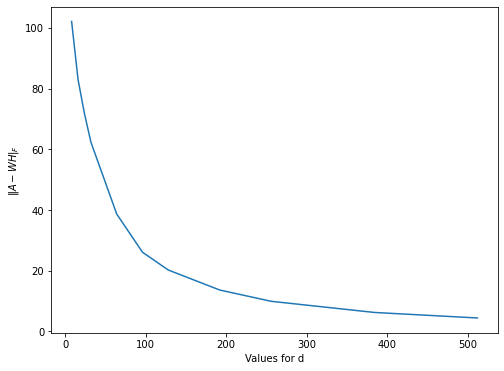

In [16]:
differences = np.zeros(11) 
d_vals = np.zeros(11)
values = [8, 16, 24, 32, 64, 96 , 128, 192, 256, 384, 512]
for count, d in enumerate(values):
    W, H, diff = NMF(faces_reshaped, d)
    differences[count] = diff[-1]
    d_vals[count] = d
    print(f'{d} : {diff[-1]}')
 
fig=plt.figure(figsize=(8,6))
plt.plot(d_vals, differences)
plt.xlabel('Values for d')
plt.ylabel(r'$\Vert A - WH \vert_{F}$')
plt.title('')
plt.show()

The plot show that the function is strictly descending, but almost converges at the end. Her vet jeg ikke helt hva man skal kommentere

# Oppgave 3

# Introduksjon

So far we have worked with the images in sterile noiseless enviroment, which is not often true in real world problems. Noise is unwanted modifactions of signal, which is commonly found in most signal processing and indeed also images. There are a variety of different reasons why noise occurs, but most physical noise behaves similarly to Gaussian distributions, and can be assumed to be independent of the original image. Therefore we wil model noise as additive Gaussian noise given by $$A_{Noisy} = A + \sigma E$$, where $\sigma>0$ is a scalar noise level and E is a matrix with the same shape as A, with all components assumed to be given the standard normal distribution. 

Simarily to previous discussion we are assuming that the opacity channel is known, and therefore assuming only the RGB channels to be noisy. In addition we will only be assuming there to be noise on non-zero pixels, and we will be clipping the values to lie between 0 and 1. This is to keep the images plottable.

With noise being defined for this discussion, one of the true strenghts of NMF can be highlighted. Namely it's abillity to denoise. If we interpret every column of W to be a mean of many noisy images with the same feature one would expect the variance generated by the noise to be reduction in variance, and therefore a reduction in noise. One could argue noise itself to be a feature and therefore the algorithm would be prone to having eigenvectors dedicated to recreating it. The differnce between noise and a true feature is that noise is random and without structure, and will therefore be harder to generalize and model for a wide array of images. This leads to a critical discussion into what value of d to choose. With lower values of d the model will learn little of the noise, with the cost of the reconstruction being poorer, which is known as underfitting. One the other hand if we choose a larger value of the, the algorithm will be able to learn more of the noise, but with image being recreated more faithfully, which is known as overfitting. The rest of the rapport will be focused discussing what values of d will lead to a balance between under- and overfitting, i.e. trying to find a best fit.

In [17]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

## 3a)


42.17105963814945


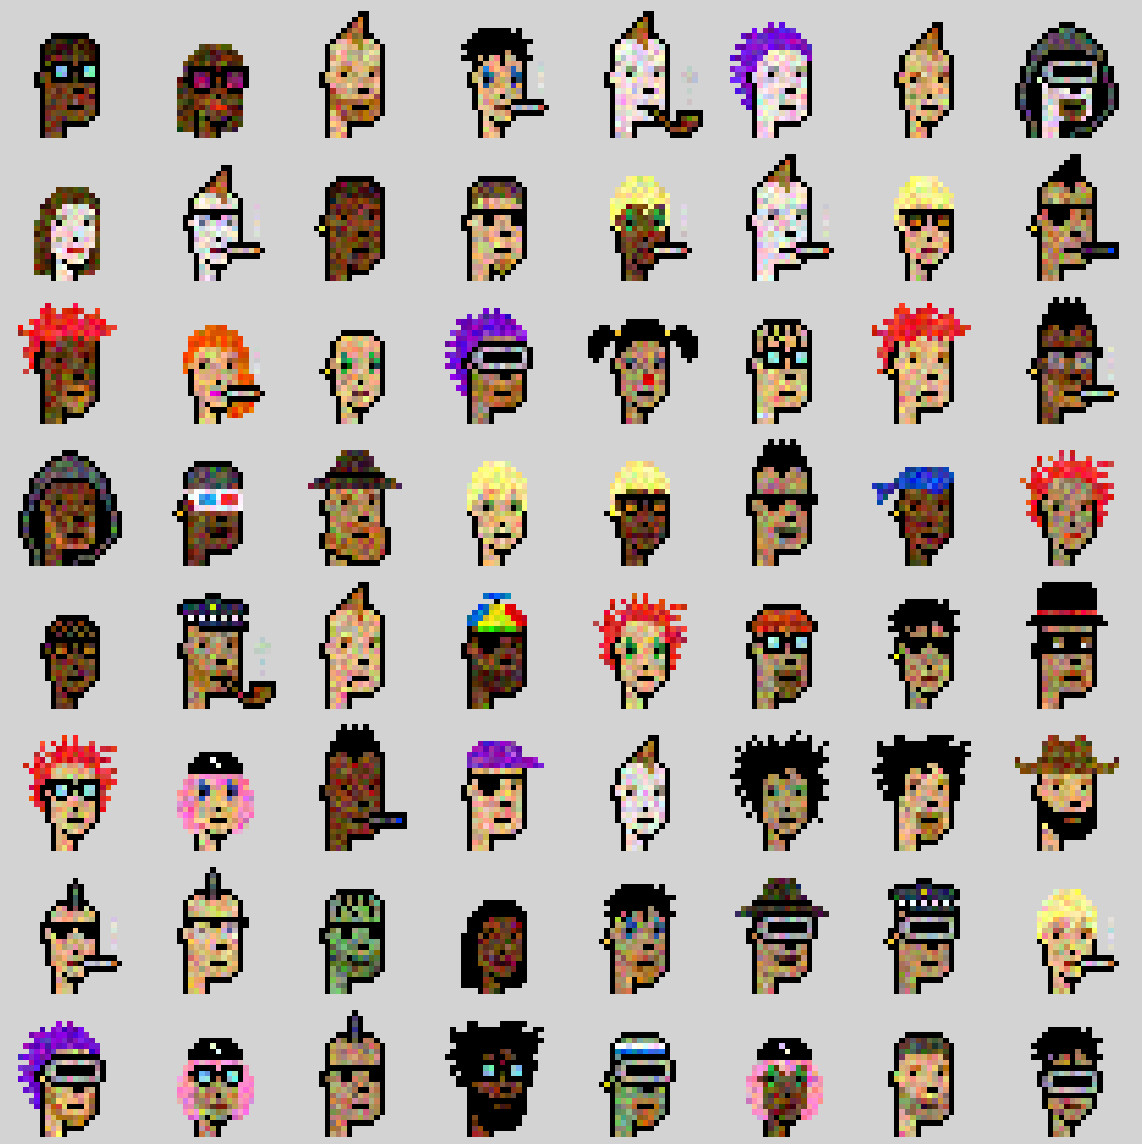

In [19]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity)

# 3b)


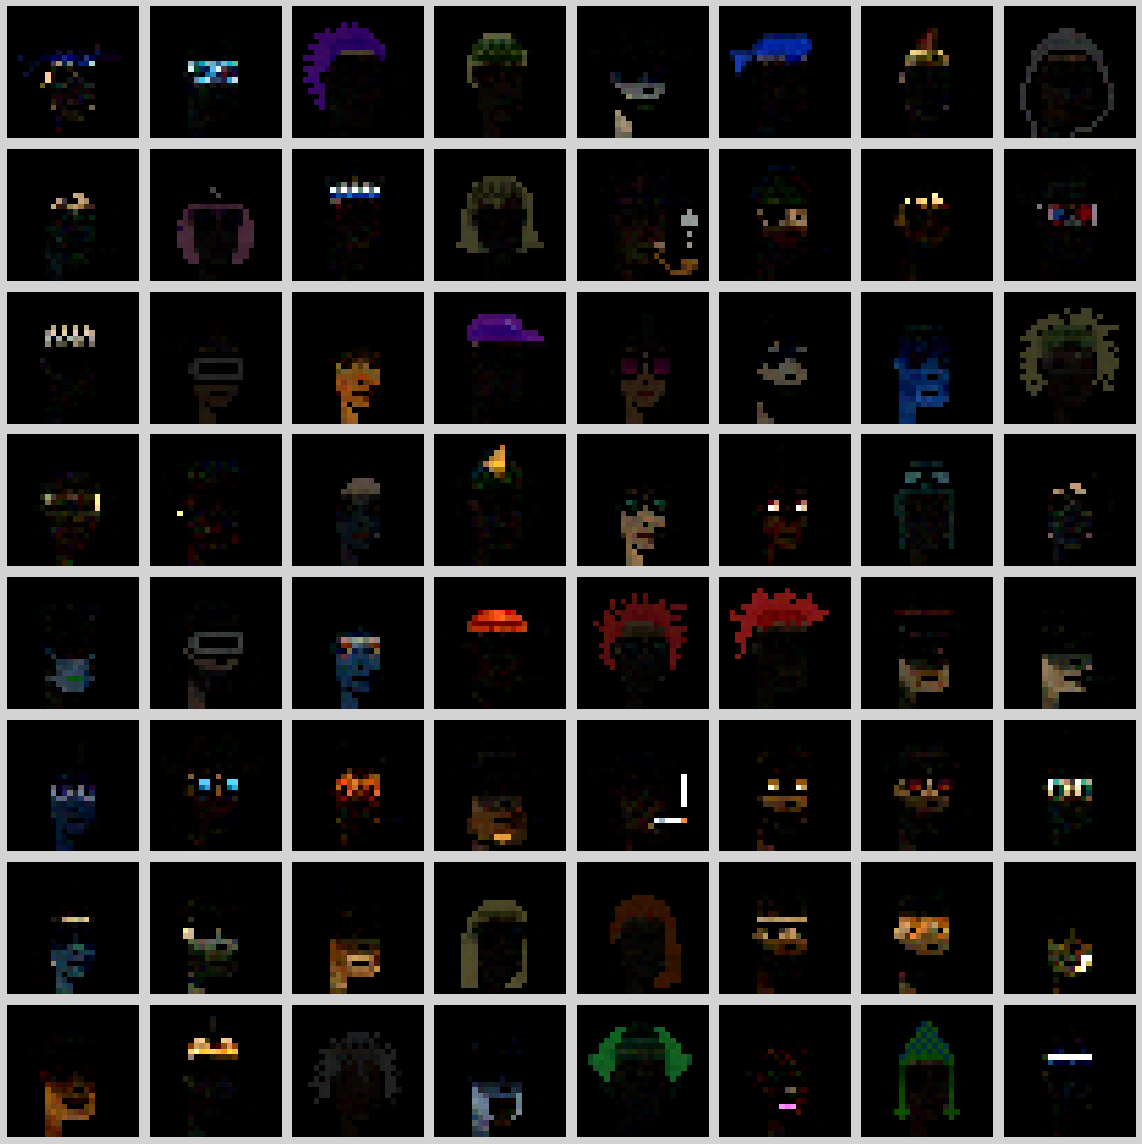

In [30]:
d = 64

W_k_Noisy, H_k_Noisy, diff = NMF(noisy_faces, d)

W_k_reshape = W_k_Noisy.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én

plotimgs(W_k_reshape, 8)

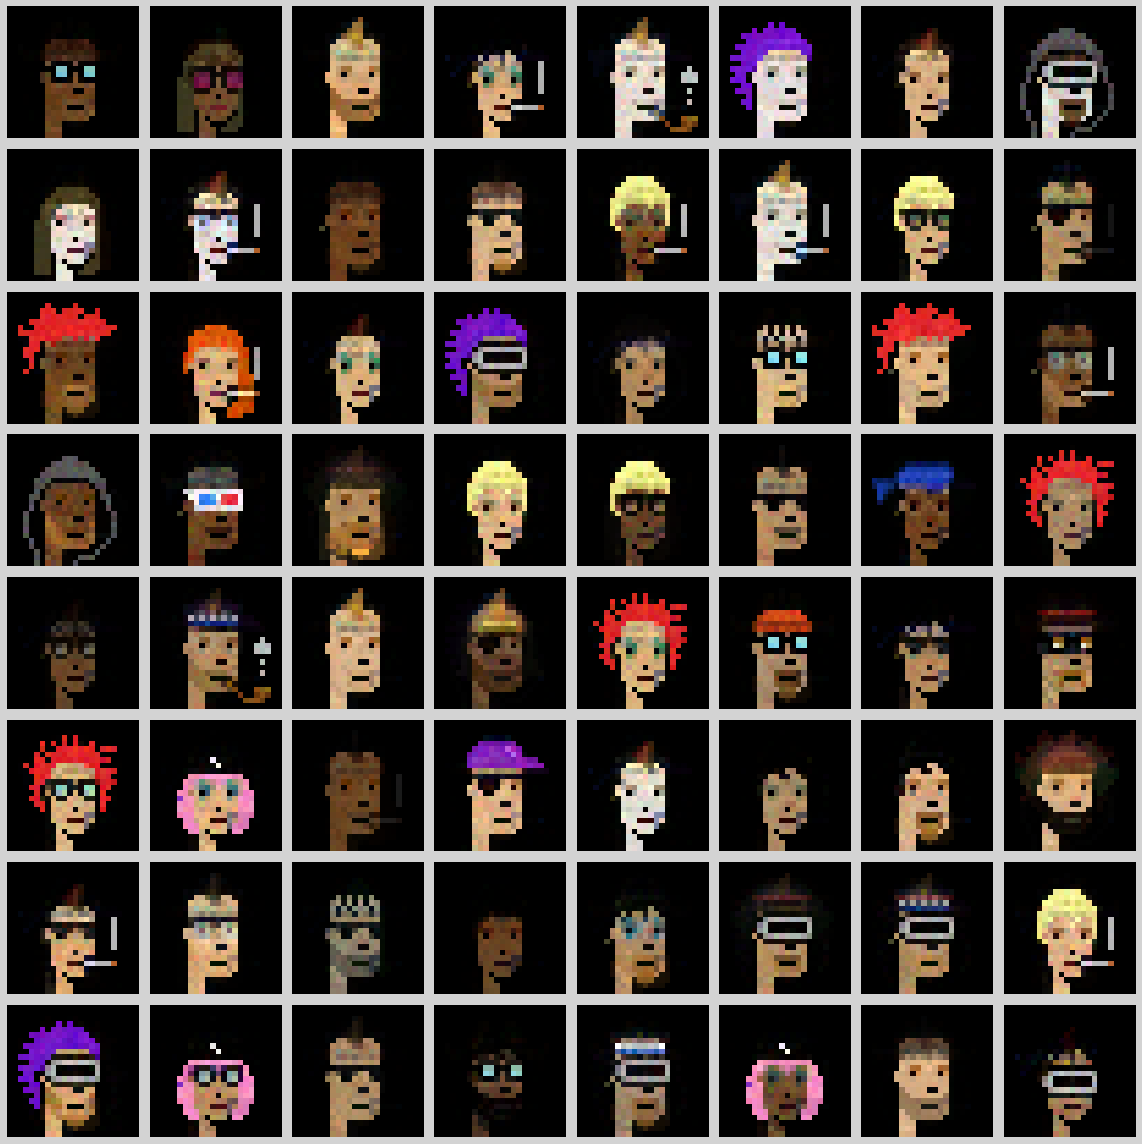

In [31]:
reconstruction = np.dot(W_k_Noisy, H_k_Noisy).reshape(24, 24, 3, 500)
reconstruction[reconstruction > 1] = 1

plotimgs(reconstruction, 8)

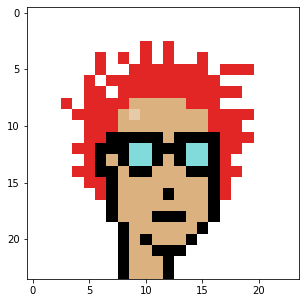

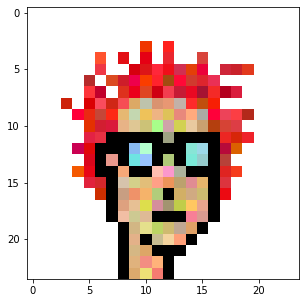

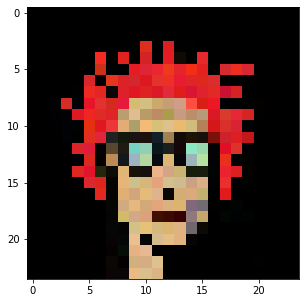

In [53]:
plt.figure(figsize = (5,5))
plt.imshow(faces[:,:,:, 40])
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(noisy_faces_with_opacity[:,:,:,40])
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(reconstruction[:,:,:, 40])
plt.show()


# 3c)


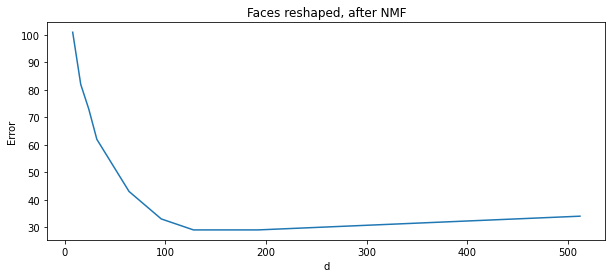

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

d_values = [8, 16, 24, 32, 64, 96 , 128, 192, 256, 384, 512]
error = np.zeros_like(d_values)

for i, d in enumerate(d_values):
    W, H, diff = NMF(noisy_faces, d)
    error[i] = np.linalg.norm(faces_reshaped - W @ H)
    
ax.plot(d_values, error)
ax.set_title("Faces reshaped, after NMF")
ax.set_xlabel("d")
ax.set_ylabel("Error")

plt.show()

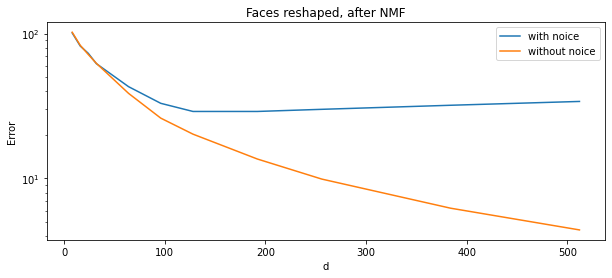

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.semilogy(d_values, error, label="with noice")
ax.semilogy(d_vals, differences, label="without noice")
ax.set_title("Faces reshaped, after NMF")
ax.set_xlabel("d")
ax.set_ylabel("Error")
ax.legend()


plt.show()

When the Frobenius norm from the noisy matrix is compared to the norm from matrix without noice, they follow each other closely from 0 to 50, but then the one with noice starts to flat out, while the other contiunes to descend. Noisy matrix looks to have its lowest value around $d=200$, after this the Norm actually gets bigger again, and dont fit to the conclusion that biggger $d$ is better that we got from earlier. The reason it increases is because from this point it starts picking up the noice in the attributes, not only the attributes itself as described earlier. This is called overfitting since the algortihm picks up diffences between the attributes, for example the bandana, which actually is not supposed to be there. On the other side of this problem is underfitting, which dont have the datapower to store all the attributes seperatly, but instead in some sort of mix. 